In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn; sn.set(font_scale=1.4)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import SVG

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
#from keras.utils.vis_utils import model_to_dot

    사용자 폴더 아래에 데이터 복사
    path는 디렉터리 경로 리스트
    label 은 단순 디렉터리 명칭 리스트
    r 이후의 내용은 단순 문자열로 처리하며 특수기호의 기능 없음

In [2]:
path = glob.glob(r'C:\rcvDataset\*')
label = os.listdir(r'C:\rcvDataset')

In [3]:
def preprocessing_cell(path, label):
    x_train=[]
    y_train=[]
    image_path=glob.glob(path+'/*.jpg')
    for x in image_path :
            img=load_img(x, target_size=(180,180))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return np.array(x_train),np.array(y_train)

In [4]:
cell, cell_y  = preprocessing_cell(r'C:\rcvDataset\cell', 0)
crackcell, crackcell_y  = preprocessing_cell(r'C:\rcvDataset\crackcell', 1)
#rod, rod_y  = preprocessing_rod(r'C:\rcvDataset\rod\rod', 2)

## 동일한 종류의 데이터셋 병합

In [5]:
temp_x = np.concatenate((cell[:2972], crackcell[:1242],cell[2972:2972+991],crackcell[1242:1242+414],
                        cell[2972+991:],crackcell[1242+414:])
                        , axis = 0)
temp_y = np.concatenate((cell_y[:2972], crackcell_y[:1242],cell_y[2972:2972+991],crackcell_y[1242:1242+414],
                        cell_y[2972+991:],crackcell_y[1242+414:]), axis = 0)

훈련데이터셋과 테스트데이터셋을 분리하고 무작위로 재배치함

디렉터리명을 라벨(암석 이름)로 저장

In [6]:
labelNames = label

In [12]:
# 훈련셋과 검증셋 분리 
trainX = temp_x[:2972+1242]
trainY = temp_y[:2972+1242]
valX = temp_x[2972+1242:2972+1242+991+414]
valY = temp_y[2972+1242:2972+1242+991+414]
testX=temp_x[2972+1242+991+414:]
testY=temp_y[2972+1242+991+414:]
print('train:',len(trainX),len(trainY),'val:',len(valX),len(valY),'test:',len(testX),len(testY))

train: 4214 4214 val: 1405 1405 test: 1406 1406


In [13]:
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    
# 새로운 모델 생성하기
last = vgg_model.output
 
# VGG16모델에 Fully Connected부분을 재구성해서 추가
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(2, activation='softmax')(x)

model = Model(vgg_model.input, pred)
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_______________________________________________________

Epoch 1/20
66/66 [==============================] - 19s 294ms/step - loss: 0.6472 - acc: 0.6979 - val_loss: 0.6589 - val_acc: 0.6690
Epoch 2/20
66/66 [==============================] - 17s 260ms/step - loss: 0.5092 - acc: 0.7753 - val_loss: 0.4367 - val_acc: 0.7929
Epoch 3/20
66/66 [==============================] - 17s 264ms/step - loss: 0.2972 - acc: 0.8870 - val_loss: 0.4774 - val_acc: 0.8071
Epoch 4/20
66/66 [==============================] - 18s 266ms/step - loss: 0.2329 - acc: 0.9105 - val_loss: 0.5362 - val_acc: 0.7851
Epoch 5/20
66/66 [==============================] - 17s 265ms/step - loss: 0.3335 - acc: 0.9093 - val_loss: 0.4222 - val_acc: 0.8149
Epoch 6/20
66/66 [==============================] - 18s 266ms/step - loss: 0.1917 - acc: 0.9257 - val_loss: 0.4025 - val_acc: 0.8320
Epoch 7/20
66/66 [==============================] - 18s 266ms/step - loss: 0.2215 - acc: 0.9321 - val_loss: 0.4159 - val_acc: 0.8263
Epoch 8/20
66/66 [==============================] - 17s 265ms/step - 

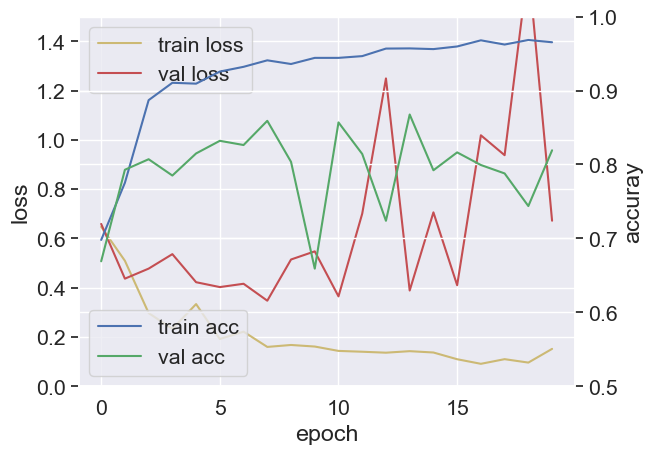

train shape: 	 (4214, 180, 180, 3)
valid shape: 	 (1405, 180, 180, 3)
test shape: 	 (1406, 180, 180, 3)


In [14]:


# one hot encode outputs
num_classes = 2
trainY = tf.keras.utils.to_categorical(trainY, num_classes)
valY = tf.keras.utils.to_categorical(valY, num_classes)
testY = tf.keras.utils.to_categorical(testY, num_classes) 
# build the model

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

# Fit the model
hist = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=20, batch_size=64, verbose=1)
model.save('model_classification_crack.h5')

# 5. 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 12*12 필터로 뽑힌 4,608개의 피쳐맵 = tf.keras.utils.to_categorical(testY, num_classes)

print ('train shape: \t', trainX.shape)
print ('valid shape: \t', valX.shape)
print ('test shape: \t', testX.shape)

In [20]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# For prediction purposes
y_pred = model.predict(testX, verbose=1)
y_pred1 = np.argmax(y_pred, axis=1)

44/44 [==============================] - 2s 50ms/step


In [24]:
testY1=np.argmax(testY, axis=1)

<AxesSubplot:>

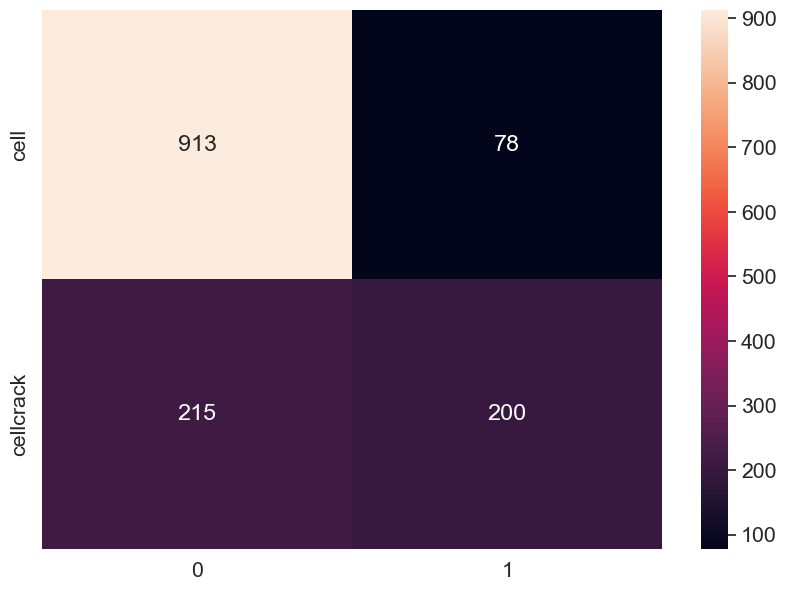

In [27]:
cm = confusion_matrix(testY1, y_pred1)
# make a dataframe using cm array
df_cm = pd.DataFrame(cm, index = ['cell','cellcrack'])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot=True,fmt='d')

In [28]:
print(classification_report(testY1, y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       991
           1       0.72      0.48      0.58       415

    accuracy                           0.79      1406
   macro avg       0.76      0.70      0.72      1406
weighted avg       0.78      0.79      0.78      1406



In [40]:
def grad_cam(input_model, image):
    nb_classes = 2  # 클래스 숫자
    preds = model.predict(image)
    predicted_label = np.argmax(preds[0])

    grad_model = tf.keras.Model(
        [model.input], [model.get_layer('block5_conv3').output, model.output]
    )

    with tf.GradientTape() as tape:
        image = tf.cast(image, tf.float32)
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, predicted_label]

    grad = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_sum(grad, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = cv2.resize(cam.numpy(), (180, 180))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cv2.applyColorMap(
        cv2.cvtColor((cam * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), cv2.COLORMAP_JET
    )
    
    return np.uint8(cam), predicted_label

In [76]:
np.argmax(testY[1])

0

1 1


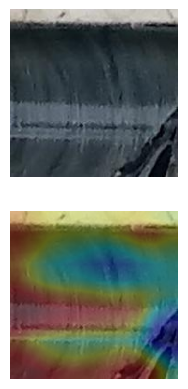

1 1


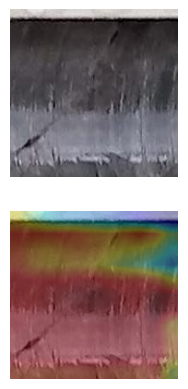

1 1


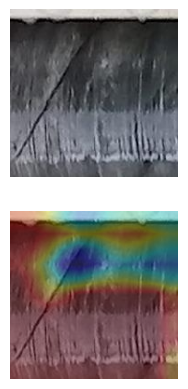

1 1


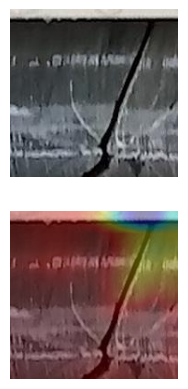

1 1


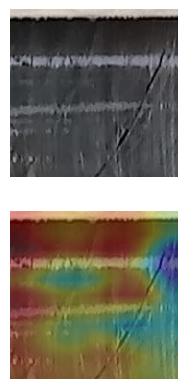

1 1


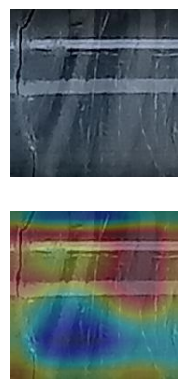

1 1


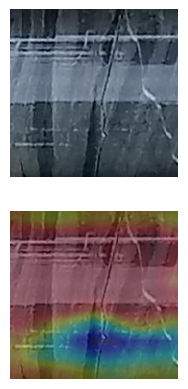

1 1


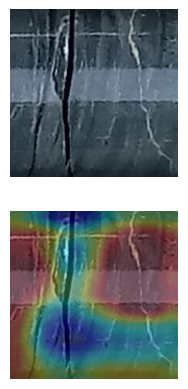

1 1


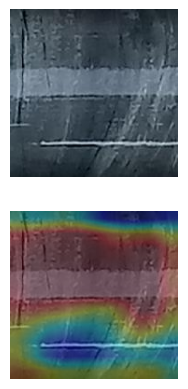

1 1


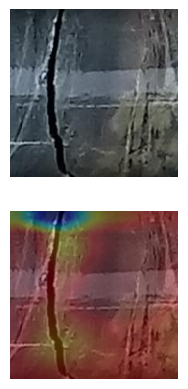

0 1


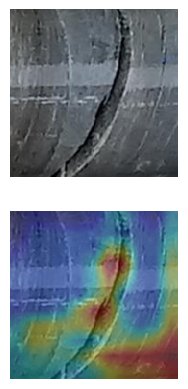

1 1


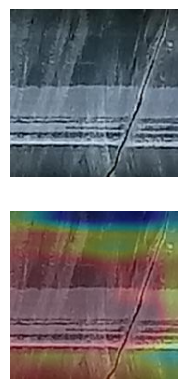

1 1


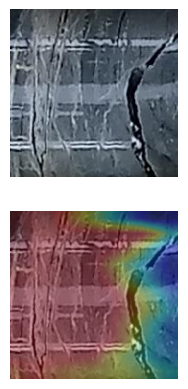

1 1


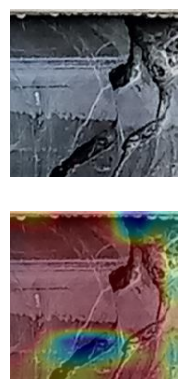

0 1


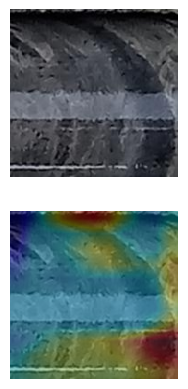

0 1


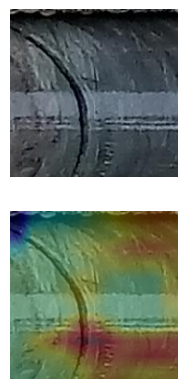

1 1


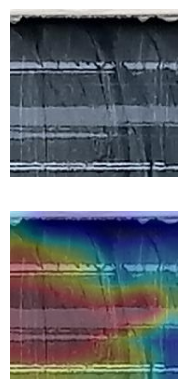

1 1


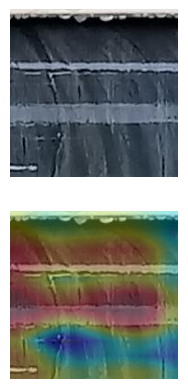

1 1


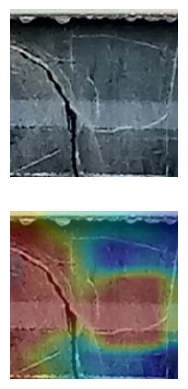

1 1


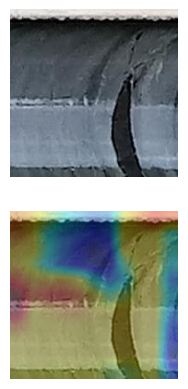

1 1


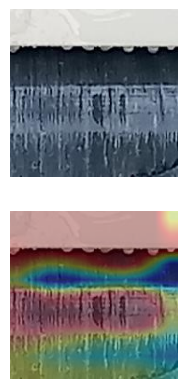

1 1


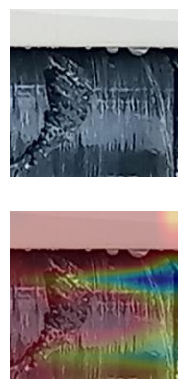

1 1


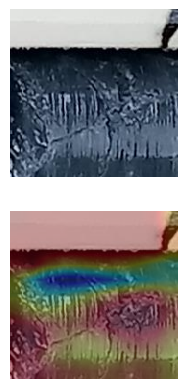

1 1


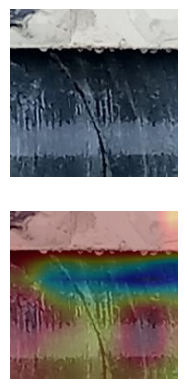

1 1


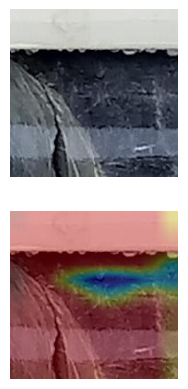

0 1


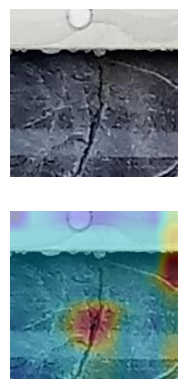

0 1


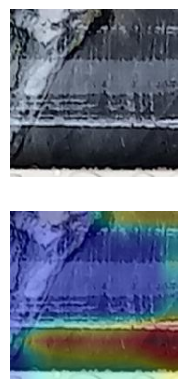

1 1


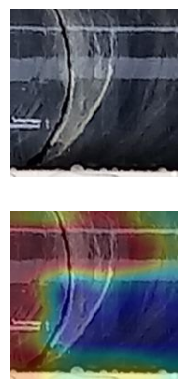

1 1


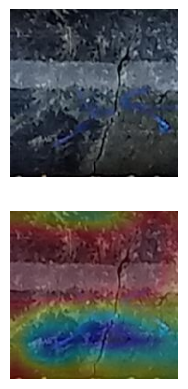

1 1


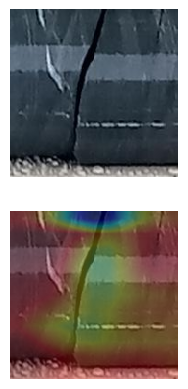

1 1


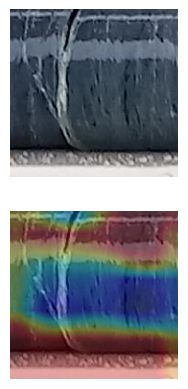

1 1


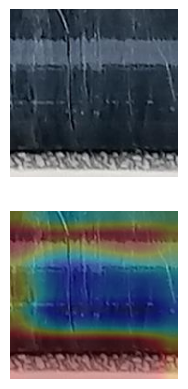

1 1


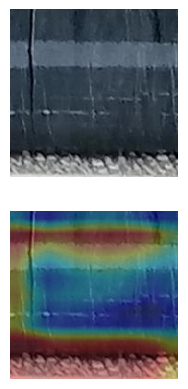

1 1


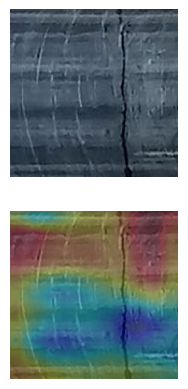

1 1


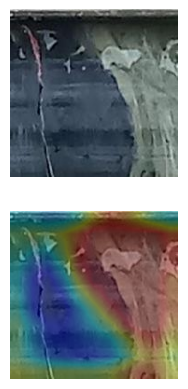

1 1


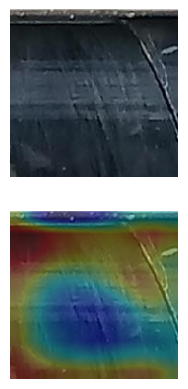

1 1


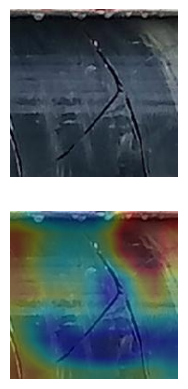

1 1


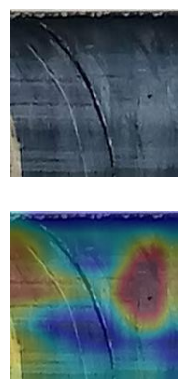

1 1


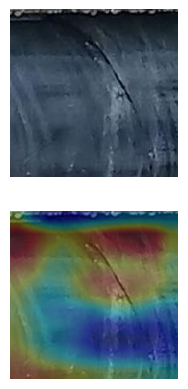

1 1


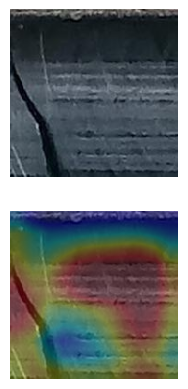

1 1


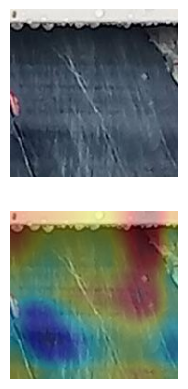

0 1


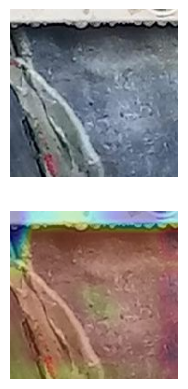

1 1


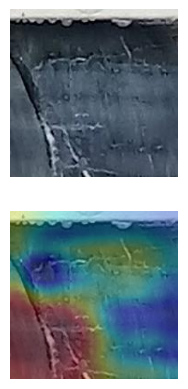

1 1


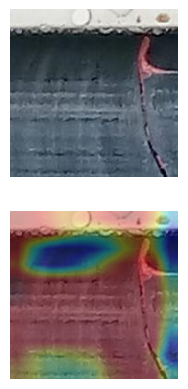

0 1


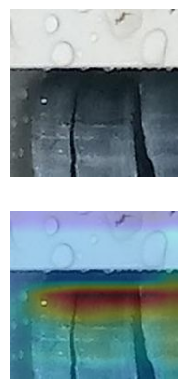

1 1


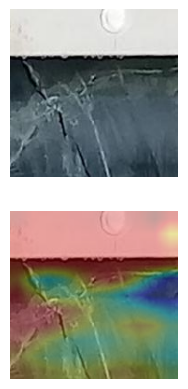

0 1


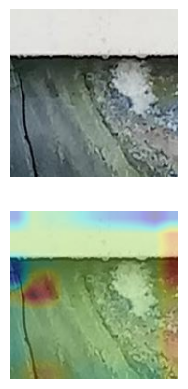

0 1


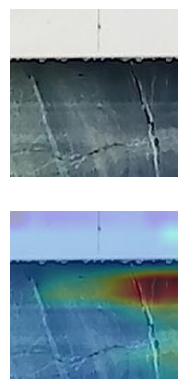

0 1


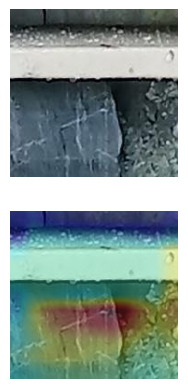

0 1


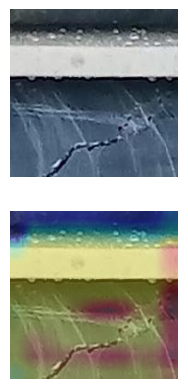

In [91]:
import cv2
data_start=1300
# CAM 출력
for i in range(50):
    input_img=testX[data_start+i]
    img=tf.expand_dims(input_img, axis=0)
    cam, plabel = grad_cam(model,img)
    print(np.argmax(np.round(model.predict(img),3)),np.argmax(testY[data_start+i]))
    plt.subplot(2, 1, 1) 
    plt.imshow(testX[data_start+i])
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.imshow(testX[data_start+i])
    plt.imshow(cam, alpha=.3)
    plt.axis('off')
    plt.show()